In [ ]:
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 5.1 MB/s 
     |████████████████████████████████| 30.5 MB 1.9 MB/s 
     |████████████████████████████████| 219 kB 59.7 MB/s 
     |████████████████████████████████| 7.7 MB 37.6 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=888f8bf193fd200a46df5deb2d0fa4993d90f516c6fd8efc09bc8e27f40053b5
  Stored in directory: /root/.cache/pip/wheels/1f/1b/b5/54affbefc8a7e2bdf1da000fc576b8a1c91338f1f327a04f4c
Successfully built pyshp
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.4.0
    Uninstalling pyproj-3.4.0:
      Successfully uninstalled pyproj-3.4.0


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap

In [2]:
#create nodes
G = nx.DiGraph()
nodes = open("Nodes.txt", 'r').read().split('\n')
lat = open("Latitude.txt", 'r').read().split('\n')
lon = open("Longitude.txt", 'r').read().split('\n')
airports = np.column_stack((nodes, lat, lon))

airports = airports[0:len(airports)-1,:]
clean_airports = []

for i in airports:
  if float(i[2]) <= 180 and float(i[2]) >= -180 and float(i[1]) <= 90 and float(i[1]) >= -90:
    clean_airports.append(i)
    G.add_node(i[0], pos = (i[1], i[2]))
clean_airports = np.asarray(clean_airports)

In [3]:
len(list(G.nodes))

5998

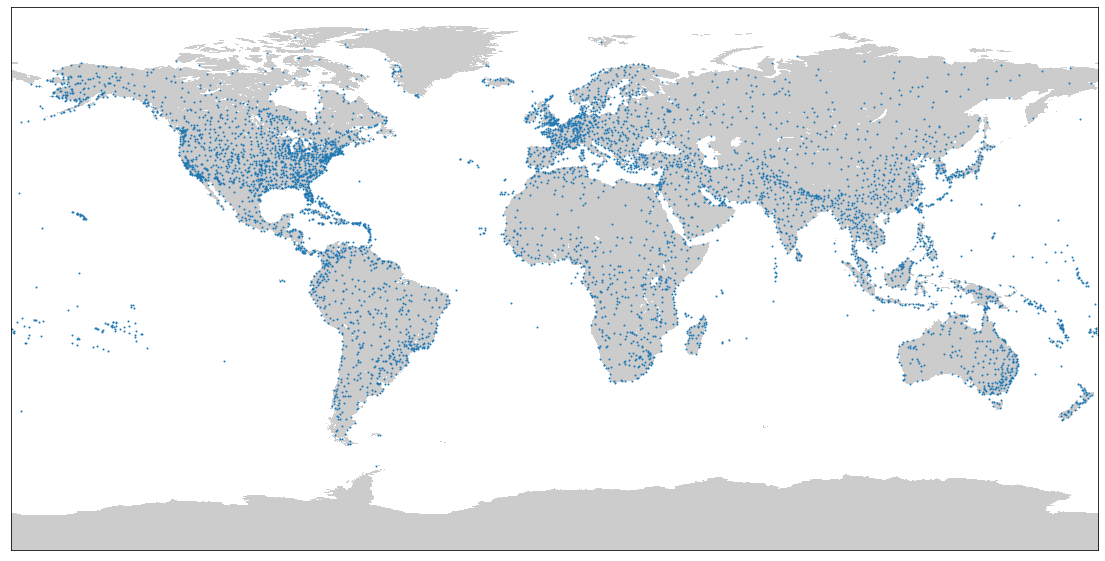

In [5]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')
for k, v in pos.items():
  pos[k] = (float(v[1]), float(v[0]))
nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()

In [6]:
sou = open("Source.txt", 'r').read().split('\n')
des = open("Destination.txt", 'r').read().split('\n')
routes = np.column_stack((sou, des))
print(len(routes))

67663


In [7]:
delete_list_sou = list(set(routes[:,0]) - set(clean_airports[:,0]))

In [8]:
delete_list_des = list(set(routes[:,1]) - set(clean_airports[:,0]))

In [9]:
print(delete_list_sou)

['SRV', 'KGX', 'CUK', 'RMI', 'BLD', 'OLH', 'LMC', 'WWP', 'NSQ', 'GNU', 'FVM', 'KOZ', 'MUC', 'LIR', 'BAQ', 'HYL', 'TFI', 'ZDY', 'TZA', 'GCW', 'TTQ', 'AOQ', 'GSM', 'DGA', 'FSZ', 'PAF', 'BVV', 'CKD', 'QUB', 'KWF', 'KTW', 'QOQ', 'KXU', 'IUI', 'IOQ', 'MPH', 'ORZ', 'CKX', 'XEQ', 'SGG', 'KTB', 'PEG', 'THD', 'PHO', 'TNO', 'TKE', 'ZBL', 'QUW', 'KGQ', 'EXI', 'CXF', 'SXP', 'EBJ', 'JIJ', 'PND', 'PLJ', 'JUK', 'BCV', 'LNV', 'KAE', 'LSA', 'PQS', 'TGC', 'LMP', 'DLI', 'CIA', 'KKB', 'TNK', 'GHE', 'IAO', 'UPK', 'WWT', 'CZH', 'TCT', 'QUV', 'MCM', 'FDE', 'CGA', 'IOT', 'BKO', 'KCL', 'NQU', 'AOS', 'OTD', 'GOA', 'PNL', 'MRA', 'TCD', 'EAR', 'KHQ', 'QFN', 'QJH', 'PYC', 'PEC', 'SYB', 'GRV', 'TAL', 'RIG', 'TQA', 'ACU', 'WBB', 'DIW', 'FLR', 'LKE', 'EDA', 'SZE', 'PUM', 'LBP', 'WTL', 'QUO', 'DIJ', 'SVR', 'RMP', 'CBS', 'SAX', 'SVC', 'RKA', 'WSX', 'IGM', 'KCQ', 'MJU', 'JJA', 'SAE', 'YKT', 'KKI', 'SZI', 'CDG', 'NIQ', 'KBU', 'BLQ', 'JUU', 'RDV', 'GSE', 'RCH', 'PSA', 'HKB', 'EBA', 'INB', 'SSB', 'MLH', 'ELL', 'SLI', 'OGM'

In [10]:
print(delete_list_des)

['SRV', 'KGX', 'CUK', 'RMI', 'BLD', 'OLH', 'LMC', 'WWP', 'NSQ', 'GNU', 'FVM', 'KOZ', 'MUC', 'LIR', 'BAQ', 'HYL', 'TFI', 'KPR', 'ZDY', 'TZA', 'GCW', 'TTQ', 'AOQ', 'GSM', 'DGA', 'FSZ', 'PAF', 'BVV', 'CKD', 'QUB', 'KWF', 'KTW', 'QOQ', 'KXU', 'IUI', 'IOQ', 'MPH', 'ORZ', 'CKX', 'XEQ', 'SGG', 'KTB', 'PEG', 'TKE', 'PHO', 'TNO', 'THD', 'ZBL', 'QUW', 'KGQ', 'EXI', 'CXF', 'SXP', 'EBJ', 'JIJ', 'KZB', 'PND', 'PLJ', 'JUK', 'BCV', 'LNV', 'KAE', 'LSA', 'PQS', 'TGC', 'LMP', 'DLI', 'CIA', 'KKB', 'TNK', 'GHE', 'IAO', 'UPK', 'WWT', 'CZH', 'TCT', 'QUV', 'MCM', 'FDE', 'CGA', 'IOT', 'BKO', 'KCL', 'NQU', 'AOS', 'OTD', 'GOA', 'PNL', 'MRA', 'TCD', 'EAR', 'KHQ', 'QFN', 'QJH', 'PYC', 'PEC', 'SYB', 'BSS', 'QFX', 'GRV', 'TAL', 'RIG', 'TQA', 'ACU', 'WBB', 'DIW', 'FLR', 'LKE', 'EDA', 'SZE', 'PUM', 'LBP', 'WTL', 'QUO', 'DIJ', 'SVR', 'RMP', 'CBS', 'SAX', 'SVC', 'RKA', 'WSX', 'IGM', 'KCQ', 'MJU', 'MTE', 'JJA', 'SAE', 'YKT', 'KKI', 'SZI', 'CDG', 'NIQ', 'KBU', 'BLQ', 'JUU', 'RDV', 'GSE', 'RCH', 'PSA', 'HKB', 'EBA', 'INB'

In [12]:
delete_list = []
for i in range(len(routes)):
  if routes[i][0] in delete_list_sou or routes[i][1] in delete_list_des:
    delete_list.append(i)
print(len(delete_list))

3933


In [13]:
routes = np.delete(routes, delete_list, 0)
print(len(routes))

63730


In [14]:
for i in routes:
  G.add_edge(i[0], i[1])

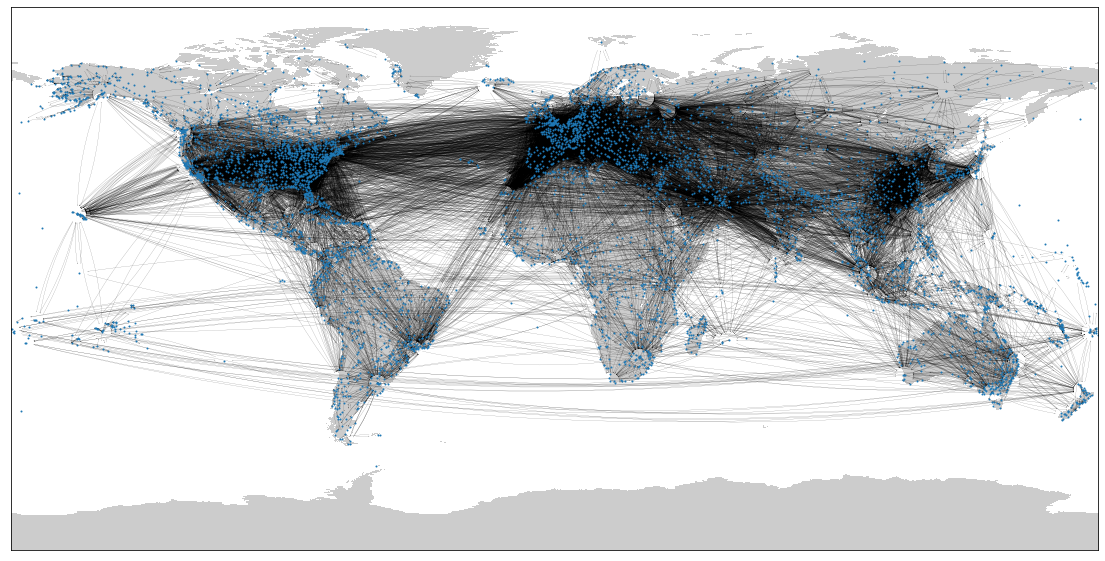

In [15]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')

for k, v in pos.items():
    pos[k] = (float(v[1]), float(v[0]))
    
nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
nx.draw_networkx_edges(G, pos,width = 0.1, arrowsize = 1 ,connectionstyle="arc3,rad=0.1")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()


In [16]:
# create edge attribute weight with default None 
nx.set_edge_attributes(G, values=None, name = 'weight')

#count the occurance of the airport in the routes database
sources, sources_counts=np.unique(routes[:,0], return_counts=True)
des, des_counts=np.unique(routes[:,1], return_counts=True)

# create edge attribute source_occurrence with default None
nx.set_node_attributes(G, values=0, name = 'so')
for node in list(sources):
    G.nodes[node]['so'] = list(sources_counts)[list(sources).index(node)]

# create edge attribute destination_occurrence with default None
nx.set_node_attributes(G, values=0, name = 'do')
for node in list(des):
    G.nodes[node]['do'] = list(des_counts)[list(des).index(node)]
  
def add_weight_to_edges(graph):
    for node in graph.nodes:
        neighbors = [n for n in G.neighbors(node)]
        for nb in neighbors:
            graph[node][nb]['weight'] = np.mean([graph.nodes[node]['so'],G.nodes[node]['do'],graph.nodes[nb]['so'],graph.nodes[nb]['do']])

add_weight_to_edges(G)

In [20]:
# create node attribute degree
nx.set_node_attributes(G, values = 0, name = 'degree')
for i in G.nodes():
  G.nodes[i]['degree'] = G.degree[i]